In [1]:
#!pip install nltk

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import os

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

1.1 Column name processing(stripped,trimmed,lowered case,dropped duplicates and replaced space with underscore if any)

In [5]:
def column_name_trim(df):
    df.columns=df.columns.str.strip()
    df=df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns= df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
clinical_notes_df=pd.read_csv('mtsamples.csv')
clinical_notes_df.drop('Unnamed: 0', axis=1, inplace=True)
clinical_notes_df=column_name_trim(clinical_notes_df)
clinical_notes_df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with compl...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [6]:
def print_categories(diff_categories):
    i=1
    for name,data in diff_categories:
        print('Category:'+str(i)+' '+name+' : '+str(len(data)))
        i=i+1

In [7]:
diff_categories=clinical_notes_df.groupby(clinical_notes_df['medical_specialty'])
print_categories(diff_categories)

Category:1 Allergy / Immunology : 7
Category:2 Autopsy : 8
Category:3 Bariatrics : 18
Category:4 Cardiovascular / Pulmonary : 372
Category:5 Chiropractic : 14
Category:6 Consult - History and Phy. : 516
Category:7 Cosmetic / Plastic Surgery : 27
Category:8 Dentistry : 27
Category:9 Dermatology : 29
Category:10 Diets and Nutritions : 10
Category:11 Discharge Summary : 108
Category:12 ENT - Otolaryngology : 98
Category:13 Emergency Room Reports : 75
Category:14 Endocrinology : 19
Category:15 Gastroenterology : 230
Category:16 General Medicine : 259
Category:17 Hematology - Oncology : 90
Category:18 Hospice - Palliative Care : 6
Category:19 IME-QME-Work Comp etc. : 16
Category:20 Lab Medicine - Pathology : 8
Category:21 Letters : 23
Category:22 Nephrology : 81
Category:23 Neurology : 223
Category:24 Neurosurgery : 94
Category:25 Obstetrics / Gynecology : 160
Category:26 Office Notes : 51
Category:27 Ophthalmology : 83
Category:28 Orthopedic : 355
Category:29 Pain Management : 62
Category:

In [8]:
db=clinical_notes_df
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in db['medical_specialty'].unique():
    db_filter = db.loc[(db['medical_specialty'] == medical_specialty)]
    word_count_temp = db_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_db = pd.DataFrame({'Medical_Specialty':medical_specialty_list, 'Word_Count':word_count_list})
word_count_db['Word_Count'] = word_count_db['Word_Count'].astype('int')
word_count_db = word_count_db.sort_values('Word_Count', ascending=False)
word_count_db.reset_index(drop=True)

,Medical_Specialty,Word_Count
0,Surgery,526754
1,Consult - History and Phy.,287961
2,Orthopedic,198489
3,Cardiovascular / Pulmonary,160867
4,General Medicine,120978
5,Neurology,110677
6,Gastroenterology,80347
7,Radiology,74969
8,Obstetrics / Gynecology,72589
9,Urology,63419


In [9]:
filtered_categories=diff_categories.filter(lambda x:x.shape[0]>65)
final_categories=filtered_categories.groupby(filtered_categories['medical_specialty'])
print_categories(final_categories)

Category:1 Cardiovascular / Pulmonary : 372
Category:2 Consult - History and Phy. : 516
Category:3 Discharge Summary : 108
Category:4 ENT - Otolaryngology : 98
Category:5 Emergency Room Reports : 75
Category:6 Gastroenterology : 230
Category:7 General Medicine : 259
Category:8 Hematology - Oncology : 90
Category:9 Nephrology : 81
Category:10 Neurology : 223
Category:11 Neurosurgery : 94
Category:12 Obstetrics / Gynecology : 160
Category:13 Ophthalmology : 83
Category:14 Orthopedic : 355
Category:15 Pediatrics - Neonatal : 70
Category:16 Radiology : 273
Category:17 SOAP / Chart / Progress Notes : 166
Category:18 Surgery : 1103
Category:19 Urology : 158


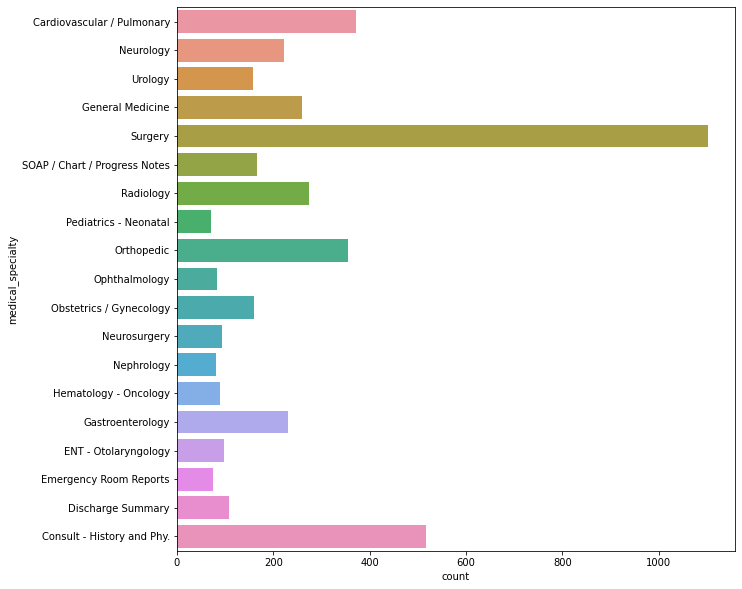

In [10]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty',data=filtered_categories)
plt.show()

In [13]:
df=filtered_categories.drop(['sample_name','description','keywords'],axis=1)
df=df[df['transcription'].notna()]
df.shape

(4483, 2)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4483 entries, 3 to 4976
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  4483 non-null   object
 1   transcription      4483 non-null   object
dtypes: object(2)
memory usage: 105.1+ KB
